In [ ]:
# Install required packages

!pip3 install torch
!pip3 install transformers
!pip3 install evaluate
!pip3 install peft
!pip3 install tqdm
!pip3 install huggingface_hub

In [ ]:

from transformers import AutoTokenizer,AutoModelForCausalLM,BitsAndBytesConfig
import torch 

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B")

# Create quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load base model with quantization
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-1.7B",quantization_config=bnb_config,device_map="auto")

from peft import LoraConfig,get_peft_model

# Create configuration for LoRA
lora_config = LoraConfig(r=8,lora_alpha=16,target_modules=["q_proj","v_proj"],lora_dropout=0.05,bias="none",task_type="CAUSAL_LM")

# Add LoRA adapters to base model
peft_model = get_peft_model(model,lora_config)

2025-11-23 14:35:43.175899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 14:35:43.185195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763897743.192352  131654 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763897743.194734  131654 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763897743.201382  131654 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load dataset
from datasets import Dataset

train_ds = Dataset.from_parquet("./dataset/train.parquet")
valid_ds = Dataset.from_parquet("./dataset/valid.parquet")
test_ds = Dataset.from_parquet("./dataset/test.parquet")


In [12]:
# Baseline: measure, how the base model works before fine tuning

from functions import evaluate_test
rogues = evaluate_test(test_ds,peft_model,tokenizer)

Device set to use cuda:0
100%|██████████| 4/4 [10:35<00:00, 158.90s/it]


In [13]:
import pandas as pd
pd.DataFrame({"name":rogues.keys(),"value":rogues.values()})

,name,value
0,rouge1,0.380262
1,rouge2,0.122562
2,rougeL,0.213466
3,rougeLsum,0.314514


In [ ]:
# Convert dataset to prompt format suitable for training
from functions import prepare_data
train_data = train_ds.map(lambda item: prepare_data(item,tokenizer),batched=False,remove_columns=train_ds.column_names,num_proc=1)
valid_data = valid_ds.map(lambda item: prepare_data(item,tokenizer),batched=False,remove_columns=valid_ds.column_names,num_proc=1)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Fine tuning pipeline

from transformers import EarlyStoppingCallback, Trainer, TrainingArguments

# Custom collator with padding
def causal_lm_collator(features):
    input_ids = [f["input_ids"] for f in features]
    attention_mask = [f["attention_mask"] for f in features]
    labels = [f["labels"] for f in features]
    
    collated = tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_mask},
        padding=True,
        return_tensors="pt"
    )
    
    # Manual padding for labels: pad_token_id = -100
    max_len = collated["input_ids"].size(1)
    padded_labels = []
    for label in labels:
        padding_len = max_len - len(label)
        padded_label = label + [-100] * padding_len
        padded_labels.append(padded_label)
    
    collated["labels"] = torch.tensor(padded_labels, dtype=torch.long)
    return collated

args = TrainingArguments(
    output_dir="./outputs/",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_steps=250,
    bf16=True,
    optim="paged_adamw_8bit",
    logging_steps=50,    
    eval_strategy="steps", 
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,    
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,    
    report_to="none"
)

trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    data_collator=causal_lm_collator,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=10,
            early_stopping_threshold=1e-4  
        )
    ],
)

In [ ]:
# Free CUDA memory
import gc
torch.cuda.empty_cache()
gc.collect()
# Train the model
result = trainer.train()

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
200,1.725800,1.766712
400,1.715900,1.718608
600,1.603700,1.676422
800,1.715700,1.663069
1000,1.672300,1.648873
1200,1.724300,1.645273
1400,1.578400,1.640532
1600,1.724600,1.639638
1800,1.675400,1.635738
2000,1.618900,1.634921


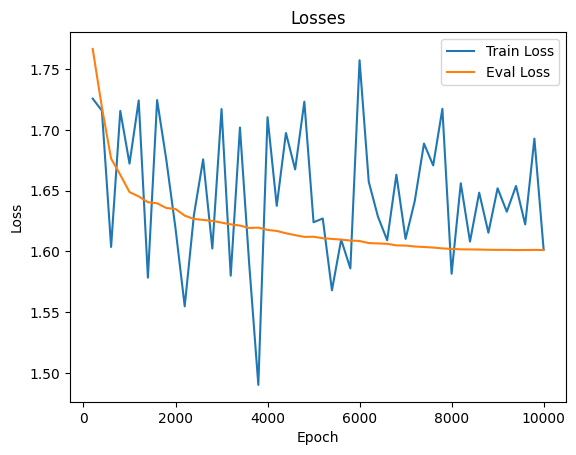

In [ ]:
# Draw loss graph

epochs = [x['step'] for x in trainer.state.log_history if 'loss' in x and x['step'] % 200 == 0]
train_losses = [x['loss'] for x in trainer.state.log_history if 'loss' in x and x['step'] % 200 == 0]
eval_losses = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]

import matplotlib.pyplot as plt
plt.plot(epochs,train_losses,label="Train Loss")
plt.plot(epochs,eval_losses,label="Eval Loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [10]:
# Calculate ROGUE metrics for fine-tuned model
from functions import evaluate_test
import pandas as pd 

rogues = evaluate_test(test_ds,peft_model,tokenizer)
pd.DataFrame({"name":rogues.keys(),"value":rogues.values()})

Device set to use cuda:0
100%|██████████| 4/4 [11:49<00:00, 177.47s/it]


,name,value
0,rouge1,0.397533
1,rouge2,0.153662
2,rougeL,0.222143
3,rougeLsum,0.365333


In [ ]:
# Save and upload the model to HuggingFace Hub

# Save tokenizer and LoRA adapters
peft_model.save_pretrained("./qwen3-pubmed-summarization")
tokenizer.save_pretrained("./qwen3-pubmed-summarization")

In [ ]:
# Login to Hugging Face

from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import create_repo, HfApi

# Create repository
repo_id = "GermanovDev/qwen3-pubmed-summarization"
create_repo(repo_id, private=False, exist_ok=True)

# Upload saved model files to the repository
api = HfApi()
api.upload_folder(
    folder_path="./qwen3-pubmed-summarization",
    repo_id=repo_id,
    commit_message="Upload Qwen3 PubMed Summarization LoRA adapter",
)